# Exploration08 - 뉴스 요약봇 만들기

뉴스 기사에 대해서 텍스트 요약을 진행하여 헤드라인을 만들어 보자.

---

### 텍스트 요약이란?

긴 길이의 문서 원본을 핵심 주제만으로 구성된 짧은 요약 문장들로 변환하는 것.  
요약 문장을 만드는 방법은 크게 2가지


#### - 추출적 요약  
  원문에서 문장들을 추출해서 요약하는 방식, 문장 분류 문제    
  결과로 나온 문장들 간의 호응이 자연스럽지 않을 수 있음  
  전통적인 머신러닝 방식인 텍스트 랭크와 같은 알고리즘을 사용  
  
  
#### - 추상적 요약
  원문의 내용이 요약된 새로운 문장을 생성, 자연어 생성의 영역  
  어텐션 메커니즘 사용으로 긴 문장도 학습할 수 있음

---

### 루브릭 평가 기준

1. Abstractive 모델 구성을 위한 텍스트 전처리 - 분석 단계, 정제 단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 진행되었나
2. 텍스트 요약 모델의 성공적인 학습 - 모델 학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약과 유사한 요약 문장을 얻을 수 있나
3. Extractive 요약을 시도해보고 abstractive 요약과 비교 - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 결과를 제시하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 전처리
  - 데이터 준비
  - 데이터 전처리
    

2) 모델 설계 및 훈련
  - 모델 설계
  - 어텐션 메커니즘
  - 모델 훈련


3) 모델 테스트
  - 인퍼런스 모델 구현
  - 추상적 요약
    

4) 추출적 요약


5) 회고

## 0. 필요 모듈 import

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# 모델 설계 필요 모듈
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 어텐션 함수
from tensorflow.keras.layers import AdditiveAttention

# 추출적 요약을 위한 모듈
from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. 데이터 로드 및 전처리

### - 데이터 준비

뉴스 내용과 이를 요약한 헤드라인이 담긴 데이터를 [여기](https://github.com/sunnysai12345/News_Summary)에서 다운로드 받는다.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="./data/news_summary_more.csv")
data = pd.read_csv('./data/news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
98099,BBC interview kid Marion eats lollipop at pres...,"Professor Robert Kelly's daughter Marion, who ..."
38560,Official poster of Akshay Kumar starrer 'Gold'...,The official poster of Akshay Kumar starrer 'G...
34495,Air India ceiling & window panels break off am...,Three passengers were injured and the inner pa...
68112,900 dengue cases reported in 1 week in Delhi,Around 900 cases of dengue were reported in th...
85882,216-kg ice cream sculpture displayed at Crimea...,Crimea's Sevastopol city hosted the first ever...
65128,"Environment important, but so are traditions: ...",Madhya Pradesh Chief Minister Shivraj Singh Ch...
7130,Ukraine Parliament votes to end Friendship Tre...,The Ukrainian Parliament on Thursday approved ...
89029,UP CM Yogi to remain an MP till Presidential p...,BJP Chief Ministers Yogi Adityanath and Manoha...
46880,India has lowest 4G LTE speed in the world at ...,India has recorded the lowest 4G LTE speed in ...
29620,Cong denies sanctioning of TN Sterlite project...,The Congress on Thursday denied that the expan...


### - 데이터 전처리 : 데이터 정리
> 텍스트를 정제하고, 중복되는 샘플과 NULL 값이 존재하는 샘플은 정리를 해준다.

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


요약에 해당하는 headlines은 동일할 수 있어도 본문 내용인 text는 동일하면 중복 데이터이므로 제거해준다.

In [5]:
# 중복샘플 데이터 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


증복을 제거한 뒤 NULL 값이 있는지 확인하고 있다면 제거해준다.

In [6]:
# 데이터 프레임에 NULL값 있는지 확인
print(data.isnull().sum()) 

headlines    0
text         0
dtype: int64


I am 과 I'm 처럼 의미는 동일하지만 다르게 쓰인 축약형을 텍스트 정규화를 거쳐 하나로 통일해 준다.  
[정규화 사전](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)은 링크를 참고했다.

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


NLTK에서 제공하는 불용어 리스트(179개)를 참고해 불용어를 제거한다.   

* 불용어  
  텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 도움이 되지 않는 단어들

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

불용어 제거, 축약형 정규화 등 전처리 과정을 함수로 만들어 처리한다.  
텍스트 분석을 위해 text열의 데이터에서는 불용어를 제거하지만, 요약 결과에 해당하는 headlines 열에는 남아있는 것이 더 자연스러워 보이므로 제거하지 않겠다.

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

 headlines에 대해서 전처리 함수를 호출, 불용어 제거를 수행하지 않으므로 두번째 인자는 False로 한다.

In [11]:
clean_headlines = []
 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

정제 과정을 거친 텍스트를 다시 데이터 프레임에 넣어준다. 

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True) # 빈 값을 가진 샘플들은 모두 Null 값으로 대체

전처리 후 빈 데이터가 생겼는지 다시 확인한 후 NULL 값이 존재한다면 제거해준다.

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [14]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### - 데이터 전처리 : 데이터 나누기

> 데이터의 크기를 결정하고 문장의 시작과 끝을 표시한 후 훈련 데이터와 테스트 데이터를 나눈다.

훈련에 사용할 샘플의 최대 길이를 정해준다.  
데이터의 전체적인 길이 분포를 시각화 하여 분석하고 적절한 길이를 임의로 정한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


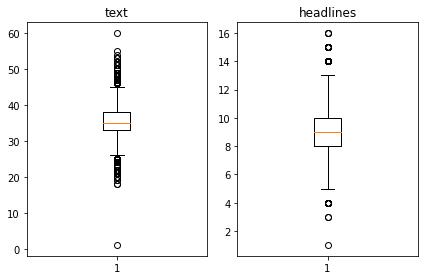

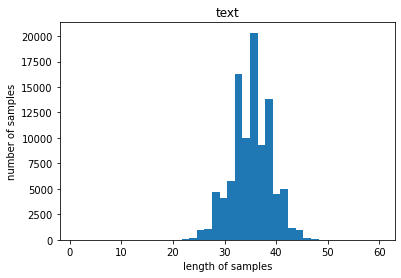

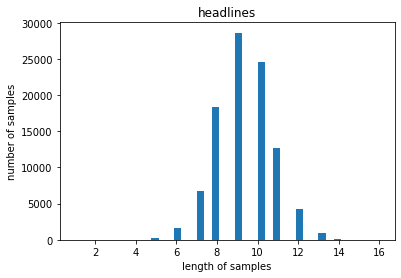

In [15]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text 데이터의 경우 길이 제한을 42로,  
headlines 데이터는 길이 제한을 12로 하면 대부분의 데이터를 포함하면서 이상치를 제거할 수 있다고 판단하였다.

In [16]:
text_max_len = 43
headlines_max_len = 12

전체 데이터에서 길이 최대 길이 이내인 데이터가 얼마나 되는지 확인해본다.

In [17]:
# 데이터의 몇 %에 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 43 이하인 샘플의 비율: 0.9871797478649857
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


약 98%의 데이터가 포함된다.  
이보다 긴 데이터들은 모두 제거해준다.

In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95935


디코더는 시작 토큰을 입력 받아 문장을 생성하기 시작하고 종료 토큰을 예측한 순간 문장 생성을 멈추므로,  
seq2seq 훈련을 위해서는 디코더의 입력과 레이블(headlines)에 시작 토큰과 종료 토큰을 추가해야 한다.  
시작 토큰을 sostoken, 종료 토큰을 eostoken으로 하여 문장의 앞뒤에 추가한다.

In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [21]:
# 인코더의 입력, 디코더의 입력과 레이블을 넘파이 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

훈련 데이터와 테스트 데이터를 분리하기 위해 데이터의 순서를 랜덤으로 섞어준다.

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

섞인 데이터를 8:2의 비율로 분리하기 위해 테스트 데이터의 크기를 정의한다.

In [23]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19187


전체 데이터를 훈련 데이터와 테스트 데이터로 나누어준다.

In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


### - 데이터 전처리 : 정수 인코딩

> 단어 사전을 정의하고 정수 인코딩을 수행한다.

Keras의 토크나이저를 이용하여 훈련 데이터로부터 단어 집합을 생성한다.

In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이 때, 빈도수가 적은 단어는 제거를 하고 훈련을 진행하고자 한다.  
빈도수가 6회 미만인 단어들이 데이터에서 얼마나 있는지 확인해보자.

In [26]:
# 빈도수가 적은 단어 제거
threshold = 6  # 빈도수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68582
등장 빈도가 5번 이하인 희귀 단어의 수: 44886
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23696
단어 집합에서 희귀 단어의 비율: 65.44865999825026
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1238814081230304


text 데이터의 전체 단어 집합에서 약 65.5%가 희귀 단어에 해당한다.  
하지만 등장하는 빈도로는 약 3.1% 밖에 되지 않으므로 이를 훈련시 제거하고자 한다.  
희귀 단어를 제외시킨 단어의 개수가 23,696이므로 이와 비슷하게 단어 사전의 크기를 20,000개로 제한한다.

In [27]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 샘플 확인
encoder_input_train[:3]

[[12,
  1742,
  38,
  5,
  1034,
  22,
  1045,
  889,
  163,
  9150,
  183,
  211,
  246,
  2725,
  38,
  1,
  1011,
  163,
  1,
  1465,
  24,
  269,
  186,
  189],
 [7536,
  38,
  2550,
  104,
  147,
  38,
  5334,
  9910,
  698,
  26,
  58,
  50,
  9,
  42,
  784,
  86,
  141,
  1438,
  503,
  269,
  19183,
  11,
  203,
  2954,
  1011,
  50,
  30],
 [84,
  22,
  9151,
  1565,
  19184,
  1174,
  1193,
  8377,
  4696,
  1475,
  34,
  231,
  1150,
  4210,
  43,
  80,
  1174,
  1193,
  11369,
  1843,
  5661,
  12380,
  14039,
  1831,
  3300,
  3494,
  2114,
  3777,
  1843,
  4445,
  1524,
  879,
  905,
  15775,
  2968]]

headlines 데이터에 대해서도 동일한 과정을 수행한다.

In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29753
등장 빈도가 4번 이하인 희귀 단어의 수: 18309
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11444
단어 집합에서 희귀 단어의 비율: 61.53665176620845
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.014693638900011


headlines 데이터의 전체 단어 집합에서 약 61.5%가 희귀 단어에 해당한다.  
하지만 등장하는 빈도로는 약 4% 밖에 되지 않으므로 이를 제거한다.  
희귀 단어를 제외시킨 단어의 개수가 18,309이므로 이와 비슷하게 단어 사전의 크기를 15,000개로 제한한다.

In [31]:
tar_vocab = 15000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 30, 791, 20, 4, 14, 515, 5, 59, 5, 643, 115], [1, 20, 4462, 117, 11446, 755, 4213, 99, 389, 4, 27], [1, 134, 4746, 3340, 6, 1987, 1218, 4, 26, 4214], [1, 118, 265, 153, 48, 1452, 406, 7, 4463, 5343, 364], [1, 144, 7137, 6, 6750, 42, 78, 545, 4582, 655]]
target
decoder  [[30, 791, 20, 4, 14, 515, 5, 59, 5, 643, 115, 2], [20, 4462, 117, 11446, 755, 4213, 99, 389, 4, 27, 2], [134, 4746, 3340, 6, 1987, 1218, 4, 26, 4214, 2], [118, 265, 153, 48, 1452, 406, 7, 4463, 5343, 364, 2], [144, 7137, 6, 6750, 42, 78, 545, 4582, 655, 2]]


희귀 단어 삭제 후 빈 샘플이 된 것은 없는지 확인하고 있다면 삭제해준다.   
decoder_input에는 sostoken, decoder_target에는 eostoken만 남아있는 샘플은 요약문이 존재하지 않는다.  

In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


길이가 서로 다른 샘플들을 같은 길이로 맞춰준다.  
앞서 정한 최대 길이보다 짧은 문장은 뒤에 0을 붙여 패딩한다.

In [33]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 2. 모델 설계 및 훈련

### - 모델 설계
> 인코더의 아웃풋이 디코더로 들어갈 수 있도록 모델을 설계한다.

인코더의 LSTM을 총 3개 층으로 구성하여 모델의 목잡도를 높인다.  
dropout과 recurrent dropout을 사용하여 regularization을 해주고 과적합을 방지한다.  

In [34]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256 # hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더의 LSTM 입력을 정의할 때 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어야 한다.

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### - 어텐션 메커니즘

> TensorFlow에 구현된 어텐션 함수를 가져와 디코더의 출력층과 결합한다.

인코더와 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동한다.

In [36]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### - 모델 훈련

EarlyStopping을 사용하여 validation loss 값이 줄어들지 않는 현상이 2회 관측되면 학습을 중단하도록 한다.

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
150/150 [==============================] - 118s 677ms/step - loss: 6.1092 - val_loss: 5.6584
Epoch 2/50
150/150 [==============================] - 101s 671ms/step - loss: 5.5964 - val_loss: 5.3852
Epoch 3/50
150/150 [==============================] - 100s 664ms/step - loss: 5.2884 - val_loss: 5.1319
Epoch 4/50
150/150 [==============================] - 99s 660ms/step - loss: 5.0154 - val_loss: 4.8892
Epoch 5/50
150/150 [==============================] - 99s 661ms/step - loss: 4.7844 - val_loss: 4.7056
Epoch 6/50
150/150 [==============================] - 99s 658ms/step - loss: 4.5894 - val_loss: 4.5711
Epoch 7/50
150/150 [==============================] - 98s 655ms/step - loss: 4.4171 - val_loss: 4.4654
Epoch 8/50
150/150 [==============================] - 99s 657ms/step - loss: 4.2635 - val_loss: 4.3553
Epoch 9/50
150/150 [==============================] - 99s 657ms/step - loss: 4.1282 - val_loss: 4.2841
Epoch 10/50
150/150 [==============================] - 98s 657ms/step 

train loss와 validation loss이 줄어드는 과정을 시각화 한다.

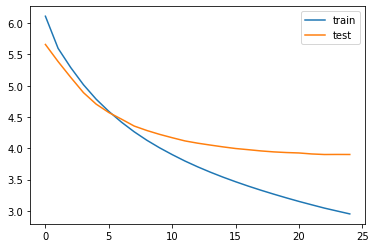

In [38]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3. 모델 테스트

### - 인퍼런스 모델 구현
 
> seq2seq는 훈련과 실제 동작의 방식이 다르다.  
인퍼런스 단계에서는 문장의 길이만큼 디코더가 반복적으로 동작해야하므로 별개의 모델을 설계한다.  
인코더와 디코더를 분리하여 설계해야 한다.

정수 인덱스 행렬로 존재하던 데이터를 텍스트로 복원하기 위해 3개의 사전을 미리 준비한다.

In [39]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [40]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계한다.

In [41]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


아래의 함수는 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수이다.

In [42]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### - 추상적 요약

테스트 결과를 확인하기 위해 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어준다.

In [43]:
# text 데이터 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# headlines 데이터 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [44]:
for i in range(0, 30, 3):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : nasa study found evidence heat source powerful us yellowstone supervolcano called mantle lies deep antarctica ice sheet maximum km believe formed million years ago antarctica covered ice since worked heat frozen continent 
실제 요약 : antarctic heat source found driving ice melt 
예측 요약 :  nasa finds ice on mars of earth like water study


원문 : supreme court wednesday ruled civil services examination marks cannot revealed right information act setting aside five year old delhi high court order asking union public service commission disclose marks court added revelation marks would compromise integrity exams 
실제 요약 : civil services marks cannot be under rti sc 
예측 요약 :  sc stays order on plea to appear on december


원문 : day supreme court ordered reopen cases sonia rahul gandhi pm narendra modi wednesday said look courage took gandhi family court door secrets told entire family added addressing rally rajasthan said victory honest 
실제 요약 : chaiwala courage took them to court pm on gandhi

- 일부 샘플에 대해서 실제 요약과 비슷해 보이는 예측을 하기도 한다. 


- 추상적 요약이므로 원문에 없는 단어를 쓴 예측 요약도 있다.


- 일부 샘플에 대해서는 관련 없는 내용과 단어들을 예측하는 경우도 있다.


- val_loss가 약 3.9이므로 어느 정도 예상한 결과이다.

## 4. 추출적 요약

> Summa 패키지에서 제공하는 summarize 모듈을 이용해 추출적 요약을 진행한다.

깔끔한 데이터프레임을 얻기 위해 동일한 데이터를 다시 불러온다.

In [45]:
text= pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

text.sample(10)

,headlines,text
16601,Karnataka CM accuses BJP of offering Ã¢ÂÂ¹5 c...,Karnataka Chief Minister HD Kumaraswamy on Thu...
31804,"As 'Boss', I need to apologise: SRK after KKR'...",Indian Premier League side Kolkata Knight Ride...
9494,Home rental startup NestAway in talks to raise...,Bengaluru-based home rental startup NestAway i...
28501,"2 infants dead, 4 critical due to faulty ACs a...",At least two infants died and four were in a c...
16865,Facebook accused of allowing bias against wome...,A lawsuit filed against Facebook on Tuesday ha...
91851,UP will become Open Defecation Free state by O...,Uttar Pradesh Chief Minister Yogi Adityanath o...
76057,Indian-origin CEO's startup raises $1 billion ...,US-based biopharmaceutical startup Roivant Sci...
53452,"Boxers return govt-gifted cows, say they don't...",Three of the six female boxers who received co...
86911,Artist installs 'Pissing Pug' statue next to '...,Artist Alex Gardega has installed a urinating ...
5437,15 bottles of pesticides poured in prasad that...,Karnataka Police has said 15 bottles of pestic...


summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행하므로 원문을 바로 입력으로 넣을 수 있다.

In [49]:
for i in range(0, 10):
    print("원문 :", text['text'][i])
    print("실제 요약 :", text['headlines'][i])
    print("추출 요약 :", summarize(text["text"][i], ratio=0.3))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : 


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : 


원문 : New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their f

원본에서 요약문으로 선택되는 문장의 비율인 ratio를 0.3으로 했을 때는 아무것도 추출되지 않는다.  
이를 조금 더 키워서 다시 결과를 확인해보자.

In [50]:
for i in range(0, 10):
    print("원문 :", text['text'][i])
    print("실제 요약 :", text['headlines'][i])
    print("추출 요약 :", summarize(text["text"][i], ratio=0.4))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

ratio를 0.4로 설정했더니 일부 샘플에 대해서만 요약이 진행되었다.  
이를 조금만 더 키우면 모든 문장에 대한 요약을 확인할 수 있을 것 같다.

In [51]:
for i in range(0, 10):
    print("원문 :", text['text'][i])
    print("실제 요약 :", text['headlines'][i])
    print("추출 요약 :", summarize(text["text"][i], ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

- 예시로 확인한 10개의 문장에 대해서 모두 요약이 되었다.


- 실제 요약인 headlines와 일치하지는 않지만 비슷한 단어가 많이 보이고있으므로 요약을 잘 진행했다고 판단할 수 있겠다.


- ratio를 0.5로 올렸더니 헤드라인으로 쓰기엔 조금 긴 문장이 추출되었다.


#### 추상적 요약 vs. 추출적 요약
<table>
  <tr>
    <td> </td> 
    <td><b><center>추상적 요약</center></b></td>
    <td><b><center>추출적 요약</center></b></td>
  </tr>
  <tr>
    <td><b>문법</b></td>  
    <td colspan="2"><center>두 방식 모두 문법적으로 완성된 문장을 만들지는 못하는 것 같다.</center></td>
  </tr>
    <td><b>핵심<br>단어</b></td> 
    <td style="text-align: left">일부 문장에 대해서는 핵심 단어를 잘 파악하여 요약에 사용하였으나<br>몇몇 샘플은 전혀 다른 요약을 예측하기도 한다.</td>
    <td style="text-align: left">원문에 있는 단어를 사용하기 때문에 실제 요약과 일치하는 단어들이 많이 보인다.</td>
    
</table>




## 5. 회고

#### - NLP 노드 아직도 어렵다  (˚ ˃̣̣̥⌓˂̣̣̥ ) ‧º

벌써 3번째 NLP 노드이다. 아직도 어렵다...  
하지만 이제는 전체적인 흐름이 조금은 눈에 들어오는 느낌이다.  
데이터 정제, 단어 사전 정의, 토큰화 등등의 과정들이 처음에는 외계어 같이 느껴졌는데 아~주 조금 친숙해졌다.  


#### - loss는 어떻게 줄이지?

다른 분야에 비해 NLP 관련 학습을 할 때 loss 값을 낮추는 것이 훨씬 어렵다.  
아직 이에 대한 이해도 부족해서 무엇을 어떻게 고쳐야 성능이 향상될지 감이 오지 않는다.  
그저 제출에 의의를 두기로한다...